#TOP

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install catboost
!pip install japanize-matplotlib
import japanize_matplotlib 
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoost
from catboost import Pool
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

     |████████████████████████████████| 76.4 MB 47 kB/s 
     |████████████████████████████████| 4.1 MB 16.0 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=97ff23931891d07aa7623a6e415a2c1fdf9a26163477f91f2613a34b70f87977
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


#データの読み込み


In [5]:

dir = "/content/drive/MyDrive/input/ai_quest_pbl01/"
sales_history = pd.read_csv(dir + "sales_history.csv")
item_categories = pd.read_csv(dir + "item_categories.csv")
category_names = pd.read_csv(dir + "category_names.csv")
test = pd.read_csv(dir + "test.csv")
sample_submission = pd.read_csv(dir + "sample_submission.csv",header=None)
# 重複削除
print('*****************************************************************************')
print(sales_history.shape)
sales_history = sales_history[~sales_history.duplicated()]
print(sales_history.shape)
print('*****************************************************************************')
# 販売個数マイナスをゼロに
# マイナスは返品か交換か何かと思うが、需要があったことに違いはないので除外する
sales_history.loc[sales_history["売上個数"] < 0, "売上個数"] = 0
print(sales_history)
print(item_categories)
print(category_names)
print(test)
print(sample_submission)

*****************************************************************************
(1119570, 5)
(1088695, 5)
*****************************************************************************
                 日付  店舗ID     商品ID  商品価格  売上個数
0        2018-01-01     9  1000001   420   1.0
1        2018-01-01     6  1000001   420   1.0
2        2018-01-01    10  1000001   420   1.0
3        2018-01-01     0  1000017   250   1.0
4        2018-01-01     1  1000017   250   1.0
...             ...   ...      ...   ...   ...
1119565  2019-10-31     8  3400006  2700   1.0
1119566  2019-10-31     7  3400009  1020   1.0
1119567  2019-10-31     7  3400012   510   1.0
1119568  2019-10-31     4  3500001   340   1.0
1119569  2019-10-31    13  3500004   420   1.0

[1088695 rows x 5 columns]
         商品ID  商品カテゴリID
0     1000001       100
1     1000002       100
2     1000003       100
3     1000004       100
4     1000005       100
...       ...       ...
9421  3500072       350
9422  3500073       350
9423  3500

#登録日

In [ ]:
pd.set_option("display.max_rows", 170)
df_id = pd.merge(sales_history, item_categories, on="商品ID")
df_id = pd.merge(df_id, category_names, on="商品カテゴリID")
publishedAt = pd.to_datetime(df_id["日付"], utc=True)
df_id = df_id[df_id["商品ID"].isin(test["商品ID"])].groupby(["日付","商品ID"],as_index = False).agg({"売上個数": np.sum})
df_id = df_id[df_id["商品ID"].isin(test["商品ID"])].groupby(["商品ID"],as_index = False).agg({"日付": np.min})
df_id.sort_values(by="日付", ascending=True, inplace=True) 
df_id

,商品ID,日付
0,1000001,2018-01-01
25,1200009,2018-01-01
123,2400011,2018-01-01
33,1200017,2018-01-01
34,1200018,2018-01-01
35,1200019,2018-01-01
119,2400007,2018-01-01
24,1200008,2018-01-01
43,1200027,2018-01-01
48,1200032,2018-01-01


#新たに登録された20商品

In [ ]:
df_id_20 = df_id[df_id["日付"] >= "2019-01-01"]
df_id_20['商品ID'].unique()

array([1400898, 3200026, 1002291, 2000162, 1600052, 1600054, 1800179,
       2500229, 2500230, 1002377, 2100152, 2400088, 1201269, 1201262,
       2800090, 2800101, 2800103, 1002503, 2900075, 1002582])

#商品ID別の売上個数

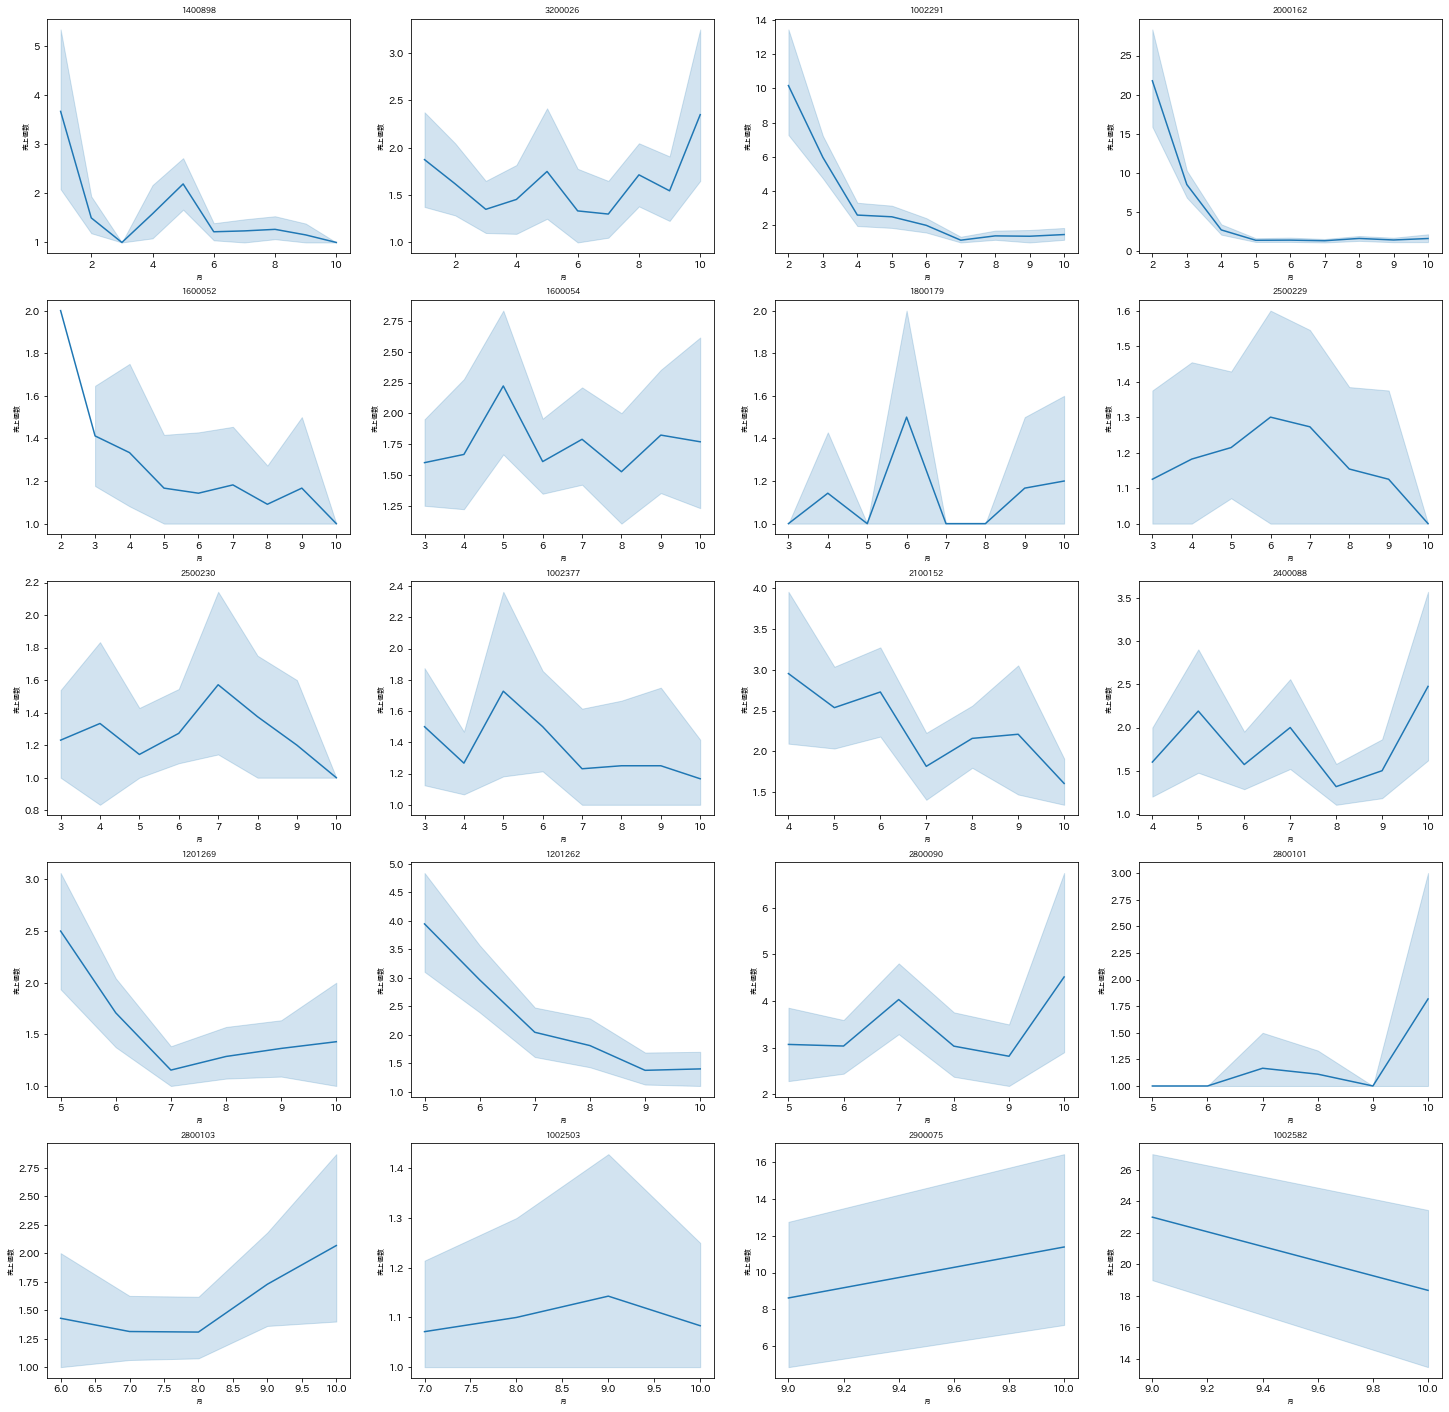

In [ ]:
df_item = pd.merge(sales_history, item_categories, on="商品ID")
df_item = pd.merge(df_item, category_names, on="商品カテゴリID")
publishedAt = pd.to_datetime(df_item["日付"], utc=True)
df_item["月"] = publishedAt.apply(lambda x: x.month)
df_item = df_item[df_item["商品ID"].isin(test["商品ID"])].groupby(["商品ID","日付","月"],as_index = False).agg({"売上個数": np.sum})

category_list = list(df_id_20["商品ID"].unique())

plt.figure(figsize=(25,25))
for i in range(len(category_list)):
    plt.subplot(5, 4, i+1)
    sns.lineplot(x="月", y="売上個数", data=df_item[df_item["商品ID"] == category_list[i]])
    plt.title(str(category_list[i]), fontsize = 8)
    plt.xlabel("月", fontsize = 7)
    plt.ylabel("売上個数", fontsize = 7)
plt.show()

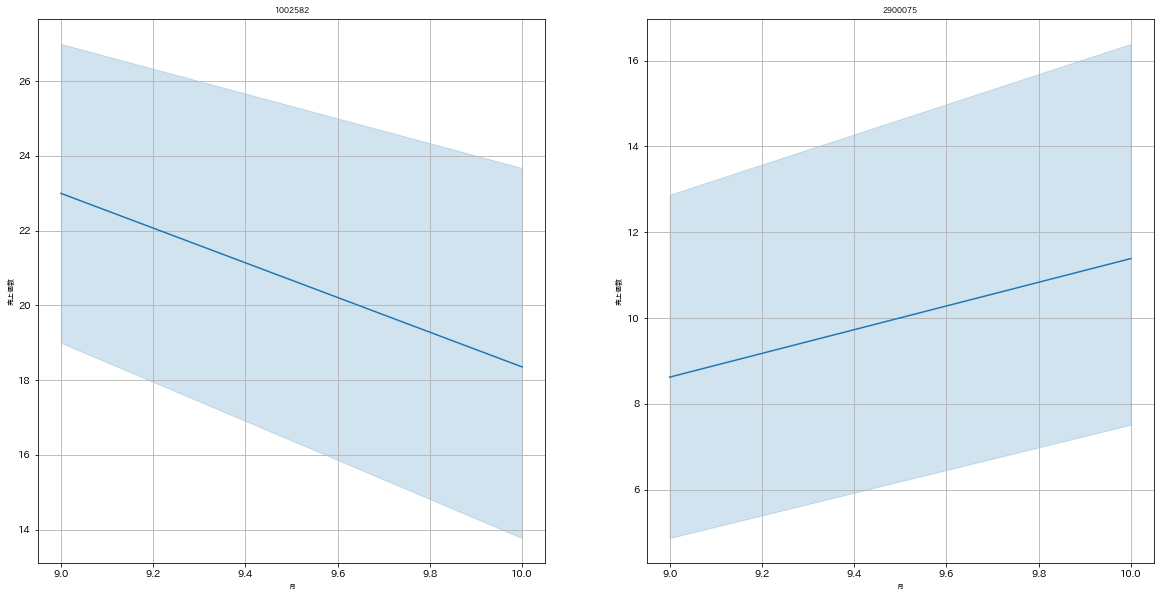

In [ ]:
category_list = [1002582,2900075]

plt.figure(figsize=(20,10))
for i in range(len(category_list)):
    plt.subplot(1, 2, i+1)
    sns.lineplot(x="月", y="売上個数", data=df_item[df_item["商品ID"] == category_list[i]])
    plt.title(str(category_list[i]), fontsize = 8)
    plt.xlabel("月", fontsize = 7)
    plt.ylabel("売上個数", fontsize = 7)
    plt.grid(True)
plt.show()

#変化率の計算

#1002582

In [ ]:
df_item[df_item["商品ID"] == 1002582].groupby(["商品ID","月"],as_index = False).agg({"売上個数": np.mean})

,商品ID,月,売上個数
0,1002582,9,23.000000
1,1002582,10,18.354839


In [ ]:
((18 - 23) / 23) * 100

-21.73913043478261

In [ ]:
item_id_1002582 = 0.2173913043478261

#2900075

In [ ]:
df_item[df_item["商品ID"] == 2900075].groupby(["商品ID","月"],as_index = False).agg({"売上個数": np.mean})

,商品ID,月,売上個数
0,2900075,9,8.625000
1,2900075,10,11.387097


In [ ]:
((11 - 9) / 9) * 100

22.22222222222222

In [ ]:
item_id_2900075 = 22.22222222222222

#20商品の9月10月

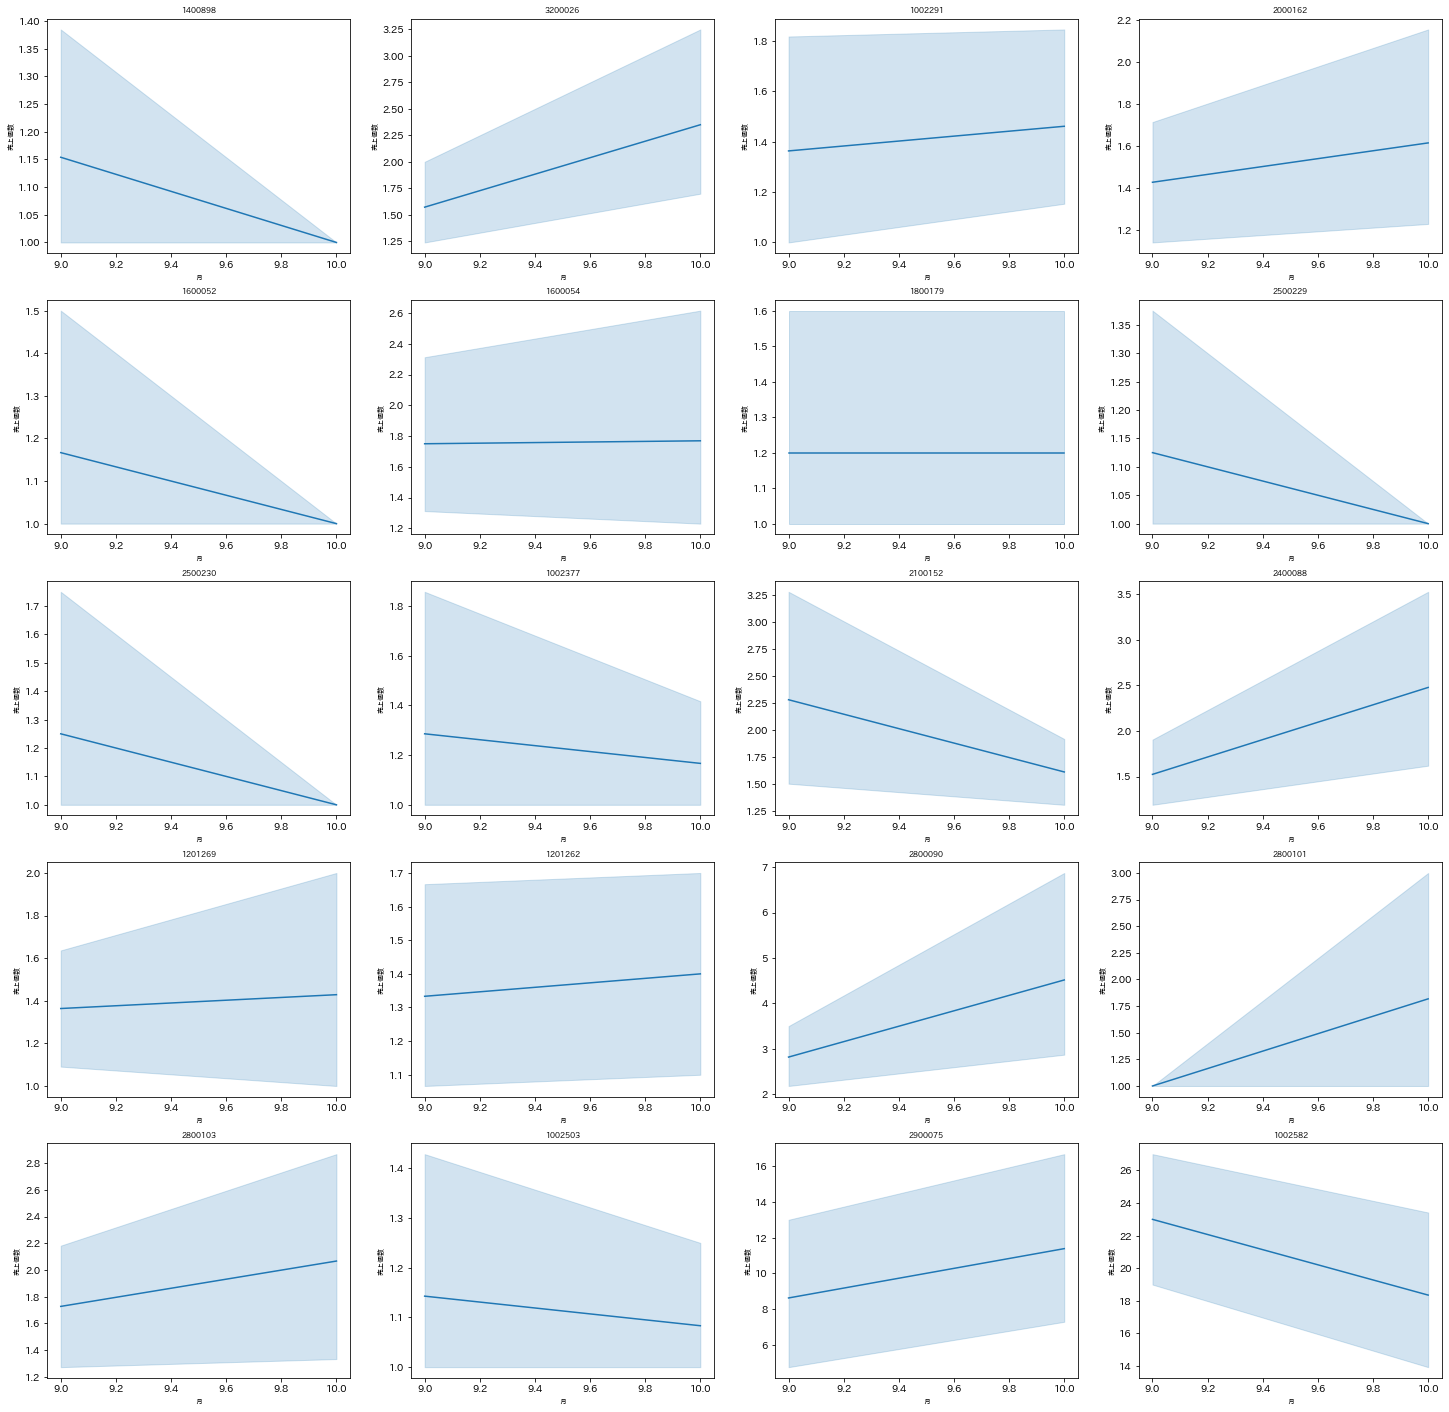

In [ ]:
df_item = pd.merge(sales_history, item_categories, on="商品ID")
df_item = pd.merge(df_item, category_names, on="商品カテゴリID")
publishedAt = pd.to_datetime(df_item["日付"], utc=True)
df_item["月"] = publishedAt.apply(lambda x: x.month)
df_item = df_item[df_item["商品ID"].isin(test["商品ID"])].groupby(["商品ID","日付","月"],as_index = False).agg({"売上個数": np.sum})
df_item = df_item[df_item["日付"] > "2019-09-01"]

category_list = list(df_id_20["商品ID"].unique())

plt.figure(figsize=(25,25))
for i in range(len(category_list)):
    plt.subplot(5, 4, i+1)
    sns.lineplot(x="月", y="売上個数", data=df_item[df_item["商品ID"] == category_list[i]])
    plt.title(str(category_list[i]), fontsize = 8)
    plt.xlabel("月", fontsize = 7)
    plt.ylabel("売上個数", fontsize = 7)
plt.show()

#カテゴリ別の売り上げ個数

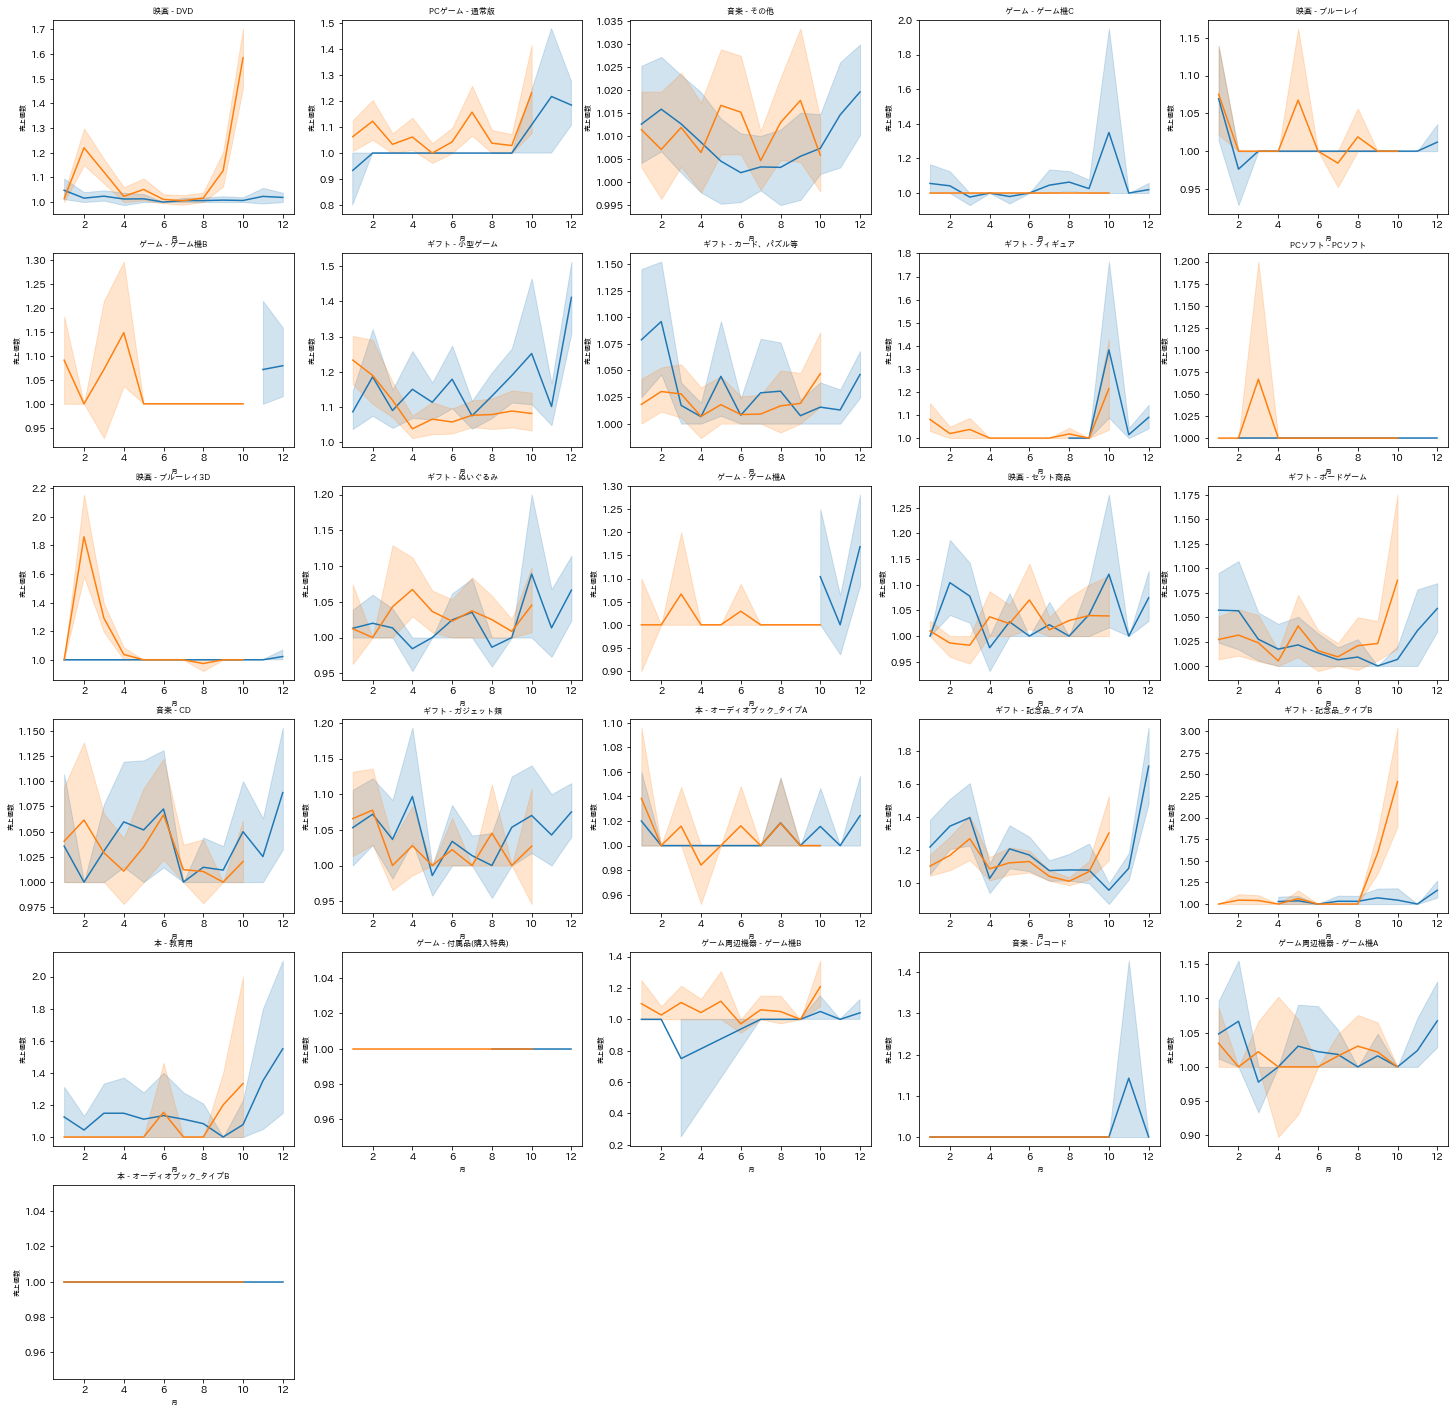

In [ ]:

df = pd.merge(sales_history, item_categories, on="商品ID")
df = pd.merge(df, category_names, on="商品カテゴリID")
publishedAt = pd.to_datetime(df["日付"], utc=True)
df["月"] = publishedAt.apply(lambda x: x.month)
df = df[df["商品ID"].isin(test["商品ID"])].groupby(["商品ID", "商品カテゴリID","商品カテゴリ名", "店舗ID", "月","日付"],as_index = False).agg({"売上個数": np.sum})

#2018年, 2019年に分ける
df_2018_group = df[df["日付"] < "2019-01-01"]
df_2019_group = df[df["日付"] >= "2019-01-01"]

category_list = list(df["商品カテゴリ名"].unique())

plt.figure(figsize=(25,25))
for i in range(len(category_list)):
    plt.subplot(6, 5, i+1)
    sns.lineplot(x="月", y="売上個数", data=df_2018_group[df_2018_group["商品カテゴリ名"] == str(category_list[i])])
    sns.lineplot(x="月", y="売上個数", data=df_2019_group[df_2019_group["商品カテゴリ名"] == str(category_list[i])])
    plt.title(str(category_list[i]), fontsize = 8)
    plt.xlabel("月", fontsize = 7)
    plt.ylabel("売上個数", fontsize = 7)
plt.show()

#前処理

In [ ]:
from datetime import datetime

df_train = pd.merge(sales_history, item_categories, on="商品ID")
df_train = pd.merge(df_train, category_names, on="商品カテゴリID")
df_train = pd.concat([df_train,df_train["商品カテゴリ名"].str.split(" - ", expand=True)],axis=1)
publishedAt = pd.to_datetime(df_train["日付"], utc=True)
df_train["月"] = publishedAt.apply(lambda x: x.month)
df_train["年月"] = df_train["日付"].str.replace("-", "").str[0:6].astype("int64")
df_train.reset_index(drop=True,inplace=True)
df_train.drop(["日付","商品カテゴリ名","商品価格"],axis=1,inplace=True)
df_train = df_train[df_train["商品ID"].isin(test["商品ID"])].groupby(["商品ID", "商品カテゴリID", "店舗ID", "年月", "月", 0, 1],as_index = False).agg({"売上個数": np.sum})

df_train

,商品ID,商品カテゴリID,店舗ID,年月,月,0,1,売上個数
0,1000001,100,0,201801,1,映画,DVD,6.0
1,1000001,100,0,201802,2,映画,DVD,3.0
2,1000001,100,0,201803,3,映画,DVD,1.0
3,1000001,100,0,201804,4,映画,DVD,2.0
4,1000001,100,0,201806,6,映画,DVD,4.0
...,...,...,...,...,...,...,...,...
25402,3500001,350,14,201806,6,本,オーディオブック_タイプB,1.0
25403,3500001,350,15,201905,5,本,オーディオブック_タイプB,1.0
25404,3500001,350,16,201809,9,本,オーディオブック_タイプB,1.0
25405,3500001,350,16,201903,3,本,オーディオブック_タイプB,1.0


In [ ]:
df_test = pd.merge(test, item_categories, on="商品ID")
df_test = pd.merge(df_test, category_names, on="商品カテゴリID")
df_test = pd.concat([df_test,df_test["商品カテゴリ名"].str.split(" - ", expand=True)],axis=1)
df_test["月"] = 12
df_test["年月"] = 201912
df_test.reset_index(drop=True,inplace=True)
df_test.drop(["index","商品カテゴリ名",],axis=1,inplace=True)

df_test

,商品ID,店舗ID,商品カテゴリID,0,1,月,年月
0,1000001,0,100,映画,DVD,12,201912
1,1000001,1,100,映画,DVD,12,201912
2,1000001,2,100,映画,DVD,12,201912
3,1000001,3,100,映画,DVD,12,201912
4,1000001,4,100,映画,DVD,12,201912
...,...,...,...,...,...,...,...
3055,3500001,13,350,本,オーディオブック_タイプB,12,201912
3056,3500001,14,350,本,オーディオブック_タイプB,12,201912
3057,3500001,15,350,本,オーディオブック_タイプB,12,201912
3058,3500001,16,350,本,オーディオブック_タイプB,12,201912


In [ ]:
from sklearn.preprocessing import LabelEncoder

#trainとtestを一緒にする
data = pd.concat([df_train, df_test], sort=False)
#データをコピー
dataCopy = data.copy()

objList = dataCopy.select_dtypes(include= "object").columns
print(objList)
le= LabelEncoder()
for feat in objList:
    dataCopy[feat]= le.fit_transform(dataCopy[feat].astype(str)) 
# dataCopy = pd.get_dummies(dataCopy, columns=[0,1])

dataCopy = dataCopy.rename(columns={0: "商品カテゴリ名A", 1: "商品カテゴリ名B"})

#trainとtestを分割
train_data = dataCopy[:len(df_train)]
test_data = dataCopy[len(df_train):].copy()
test_data.drop(["売上個数"],axis=1,inplace=True)
print(train_data)
print(test_data)

Index([0, 1], dtype='object')
          商品ID  商品カテゴリID  店舗ID      年月   月  商品カテゴリ名A  商品カテゴリ名B  売上個数
0      1000001       100     0  201801   1         5         1   6.0
1      1000001       100     0  201802   2         5         1   3.0
2      1000001       100     0  201803   3         5         1   1.0
3      1000001       100     0  201804   4         5         1   2.0
4      1000001       100     0  201806   6         5         1   4.0
...        ...       ...   ...     ...  ..       ...       ...   ...
25402  3500001       350    14  201806   6         6         6   1.0
25403  3500001       350    15  201905   5         6         6   1.0
25404  3500001       350    16  201809   9         6         6   1.0
25405  3500001       350    16  201903   3         6         6   1.0
25406  3500001       350    17  201812  12         6         6   1.0

[25407 rows x 8 columns]
         商品ID  商品カテゴリID  店舗ID      年月   月  商品カテゴリ名A  商品カテゴリ名B
0     1000001       100     0  201912  12         5   

#ターゲットエンコーディング

In [ ]:
from sklearn.model_selection import StratifiedKFold
train_target_data = train_data.copy()

train_target_data["target_enc"] = np.nan

folds = StratifiedKFold(n_splits= 5, shuffle=True,random_state=0)
for train_ind, val_ind in folds.split(train_target_data,train_target_data["月"]):
    # 訓練データと検証データを分ける
    x_train = train_target_data.iloc[train_ind].copy()
    x_val = train_target_data.iloc[val_ind].copy()
    # 訓練データを"月"でgroupbyを行い、"売上個数"の平均を求める。 
    x_train["target_enc"] = x_train.groupby("月")["売上個数"].transform(np.mean)
    # 検証データを使用しないで"月"カラムに対する売上個数の平均を求める
    x_val["target_enc"] = x_val["月"].map(x_train.groupby("月")["売上個数"].mean())  
    # 検証データの行にtarget_encodingを入れる
    train_target_data.loc[train_target_data.index[val_ind], "target_enc"] = x_val["target_enc"]
train_target_data

,商品ID,商品カテゴリID,店舗ID,年月,月,商品カテゴリ名A,商品カテゴリ名B,売上個数,target_enc
0,1000001,100,0,201801,1,5,1,6.0,1.975996
1,1000001,100,0,201802,2,5,1,3.0,2.026563
2,1000001,100,0,201803,3,5,1,1.0,2.003166
3,1000001,100,0,201804,4,5,1,2.0,1.753448
4,1000001,100,0,201806,6,5,1,4.0,1.809551
...,...,...,...,...,...,...,...,...,...
25402,3500001,350,14,201806,6,6,6,1.0,1.809551
25403,3500001,350,15,201905,5,6,6,1.0,1.790433
25404,3500001,350,16,201809,9,6,6,1.0,1.780200
25405,3500001,350,16,201903,3,6,6,1.0,2.043272


In [ ]:
test_target_data = test_data.copy()
target = train_target_data.groupby("月").agg({"target_enc": np.mean}).reset_index()
test_target_data = pd.merge(test_target_data, target, on="月")
test_target_data

,商品ID,商品カテゴリID,店舗ID,年月,月,商品カテゴリ名A,商品カテゴリ名B,target_enc
0,1000001,100,0,201912,12,5,1,2.661569
1,1000001,100,1,201912,12,5,1,2.661569
2,1000001,100,2,201912,12,5,1,2.661569
3,1000001,100,3,201912,12,5,1,2.661569
4,1000001,100,4,201912,12,5,1,2.661569
...,...,...,...,...,...,...,...,...
3055,3500001,350,13,201912,12,6,6,2.661569
3056,3500001,350,14,201912,12,6,6,2.661569
3057,3500001,350,15,201912,12,6,6,2.661569
3058,3500001,350,16,201912,12,6,6,2.661569


In [ ]:
X_train_stack = train_target_data.drop("売上個数", axis=1).copy()
X_test_stack = test_target_data.copy()

X = train_target_data.drop("売上個数", axis=1)
y = train_target_data["売上個数"]

#LGBM

In [ ]:
categorical_features = ["商品ID", "商品カテゴリID", "店舗ID",]#"商品カテゴリ名A","商品カテゴリ名B"

scores = []
X_train_stack_list_lgb = []
X_test_stack_list_lgb = []
lgb_params = {
      "objective": "regression", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      "random_state" : 0,
      "learning_rate" : 0.01,
    }

kf = KFold(n_splits=5,random_state=0, shuffle=True)
for i,(train_index, valid_index) in enumerate(kf.split(X,y)):
  print("Fold : ", i + 1)
  X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
  y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

  lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features,)# free_raw_data = False)
  lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train,categorical_feature=categorical_features, )# free_raw_data = False))
  model = lgb.train(params=lgb_params,
                    train_set=lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    num_boost_round=1000000, 
                    early_stopping_rounds=100,        
                    verbose_eval=100,
                    categorical_feature=categorical_features,             
                    )
  pred = model.predict(X_valid,num_iteration=model.best_iteration)
  t_pred = model.predict(test_target_data,num_iteration=model.best_iteration)
  X_train_stack_list_lgb.append(pred)
  X_test_stack_list_lgb.append(t_pred)
  scores.append(np.sqrt(mean_squared_error(y_valid, pred)))

X_train_stack["lgb"] = np.concatenate(X_train_stack_list_lgb) 
X_test_stack["lgb"] = np.mean(X_test_stack_list_lgb, axis=0)
print(scores)
print(sum(scores) / len(scores))

Fold :  1
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's rmse: 1.68838	valid_1's rmse: 1.9247
[200]	training's rmse: 1.49013	valid_1's rmse: 1.765
[300]	training's rmse: 1.38927	valid_1's rmse: 1.68558
[400]	training's rmse: 1.32884	valid_1's rmse: 1.64898
[500]	training's rmse: 1.29037	valid_1's rmse: 1.62515
[600]	training's rmse: 1.2606	valid_1's rmse: 1.61238
[700]	training's rmse: 1.23542	valid_1's rmse: 1.59921
[800]	training's rmse: 1.21197	valid_1's rmse: 1.59031
[900]	training's rmse: 1.19017	valid_1's rmse: 1.57804
Early stopping, best iteration is:
[893]	training's rmse: 1.19319	valid_1's rmse: 1.57531
Fold :  2
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's rmse: 1.69337	valid_1's rmse: 1.90028
[200]	training's rmse: 1.48871	valid_1's rmse: 1.74772
[300]	training's rmse: 1.3897	valid_1's rmse: 1.67274
[400]	training's rmse: 1.32513	valid_1's rmse: 1.61796
[500]	training's rmse: 1.27964	valid_1's rmse: 1.58304
[600]	training's rmse: 1.24293	valid_1's rmse: 1.56435
[700]	training's rmse: 1.21425	valid_1's rmse: 1.54684
[800]	training's rmse: 1.18841	valid_1's rmse: 1.53642
[900]	training's rmse: 1.16193	valid_1's rmse: 1.53461
Early stopping, best iteration is:
[897]	training's rmse: 1.16346	valid_1's rmse: 1.53383
Fold :  3
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's rmse: 1.72994	valid_1's rmse: 1.78377
[200]	training's rmse: 1.51664	valid_1's rmse: 1.63716
[300]	training's rmse: 1.41132	valid_1's rmse: 1.5536
[400]	training's rmse: 1.34784	valid_1's rmse: 1.51305
[500]	training's rmse: 1.30139	valid_1's rmse: 1.49287
[600]	training's rmse: 1.27073	valid_1's rmse: 1.47866
[700]	training's rmse: 1.24386	valid_1's rmse: 1.46544
[800]	training's rmse: 1.2119	valid_1's rmse: 1.45295
[900]	training's rmse: 1.18597	valid_1's rmse: 1.44083
[1000]	training's rmse: 1.16176	valid_1's rmse: 1.43689
[1100]	training's rmse: 1.14165	valid_1's rmse: 1.43276
[1200]	training's rmse: 1.1258	valid_1's rmse: 1.43079
[1300]	training's rmse: 1.11082	valid_1's rmse: 1.42981
[1400]	training's rmse: 1.09656	valid_1's rmse: 1.42759
[1500]	training's rmse: 1.08235	valid_1's rmse: 1.42469
[1600]	training's rmse: 1.067	valid_1's rmse: 1.423
[1700]	training's rmse: 1.05449	valid_1's rmse: 1.42152
[1800]	training's rmse: 1.04117	valid_1's rmse: 1.42008
[1900]	t

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's rmse: 1.72016	valid_1's rmse: 1.64349
[200]	training's rmse: 1.50347	valid_1's rmse: 1.50946
[300]	training's rmse: 1.40316	valid_1's rmse: 1.46657
[400]	training's rmse: 1.33911	valid_1's rmse: 1.44014
[500]	training's rmse: 1.29621	valid_1's rmse: 1.43158
[600]	training's rmse: 1.25612	valid_1's rmse: 1.42809
[700]	training's rmse: 1.22456	valid_1's rmse: 1.42349
[800]	training's rmse: 1.19534	valid_1's rmse: 1.4228
Early stopping, best iteration is:
[727]	training's rmse: 1.2159	valid_1's rmse: 1.4194
Fold :  5
Training until validation scores don't improve for 100 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's rmse: 1.73591	valid_1's rmse: 1.67701
[200]	training's rmse: 1.52217	valid_1's rmse: 1.49435
[300]	training's rmse: 1.41418	valid_1's rmse: 1.43786
[400]	training's rmse: 1.34904	valid_1's rmse: 1.41723
[500]	training's rmse: 1.30284	valid_1's rmse: 1.41137
[600]	training's rmse: 1.26619	valid_1's rmse: 1.40421
[700]	training's rmse: 1.2343	valid_1's rmse: 1.4072
Early stopping, best iteration is:
[651]	training's rmse: 1.24996	valid_1's rmse: 1.40292
[1.5753134823314923, 1.5338295252107896, 1.4177810710115435, 1.4194025806493338, 1.4029245282832226]
1.4698502374972766


#XGB


In [ ]:
scores = []
X_train_stack_list_xgb = []
X_test_stack_list_xgb = []
xgb_params = {
      "objective": "reg:squarederror", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      "random_state" : 0,
      "learning_rate" : 0.1,
    }

kf = KFold(n_splits=5,random_state=0, shuffle=True)
for i,(train_index, valid_index) in enumerate(kf.split(X,y)):
  print("Fold : ", i + 1)
  X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
  y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

  xgb_train = xgb.DMatrix(X_train, label=y_train, feature_names=X.columns)
  xgb_valid = xgb.DMatrix(X_valid, label=y_valid, feature_names=X.columns)
  xgb_submit = xgb.DMatrix(test_target_data, feature_names=X.columns)
  model = xgb.train(xgb_params,
                    xgb_train,
                    evals=[(xgb_train, "Train"),(xgb_valid, "Valid")],
                    num_boost_round=1000000, 
                    early_stopping_rounds=100,        
                    verbose_eval=100,      
                    )
  pred = model.predict(xgb_valid)
  t_pred = model.predict(xgb_submit)
  X_train_stack_list_xgb.append(pred)
  X_test_stack_list_xgb.append(t_pred)
  scores.append(np.sqrt(mean_squared_error(y_valid, pred)))

X_train_stack["xgb"] = np.concatenate(X_train_stack_list_xgb) 
X_test_stack["xgb"] = np.mean(X_test_stack_list_xgb, axis=0)

print(scores)
print(sum(scores) / len(scores))

Fold :  1
[0]	Train-rmse:2.542	Valid-rmse:2.68693
Multiple eval metrics have been passed: 'Valid-rmse' will be used for early stopping.

Will train until Valid-rmse hasn't improved in 100 rounds.
[100]	Train-rmse:1.26894	Valid-rmse:1.70008
[200]	Train-rmse:1.12852	Valid-rmse:1.66881
[300]	Train-rmse:1.03846	Valid-rmse:1.6583
[400]	Train-rmse:0.971323	Valid-rmse:1.6448
[500]	Train-rmse:0.919861	Valid-rmse:1.63579
Stopping. Best iteration:
[479]	Train-rmse:0.929037	Valid-rmse:1.63414

Fold :  2
[0]	Train-rmse:2.54138	Valid-rmse:2.60713
Multiple eval metrics have been passed: 'Valid-rmse' will be used for early stopping.

Will train until Valid-rmse hasn't improved in 100 rounds.
[100]	Train-rmse:1.25831	Valid-rmse:1.70058
[200]	Train-rmse:1.12814	Valid-rmse:1.66132
[300]	Train-rmse:1.0413	Valid-rmse:1.64803
[400]	Train-rmse:0.972037	Valid-rmse:1.63943
[500]	Train-rmse:0.918446	Valid-rmse:1.63628
Stopping. Best iteration:
[481]	Train-rmse:0.927581	Valid-rmse:1.63566

Fold :  3
[0]	Train-r

#CAT

In [ ]:
categorical_features = ["商品ID", "商品カテゴリID", "店舗ID","商品カテゴリ名A","商品カテゴリ名B"]#

scores = []
X_train_stack_list_cat = []
X_test_stack_list_cat = []
cat_params = { 
      "loss_function": "RMSE",
      "random_state" : 0,
      "learning_rate" : 0.1,
      "num_boost_round" : 1000000,
      "early_stopping_rounds" : 100,
      "verbose_eval" : 100
    }


kf = KFold(n_splits=5,random_state=0, shuffle=True)
for i,(train_index, valid_index) in enumerate(kf.split(X,y)):
  print("Fold : ", i + 1)
  X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
  y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

  cat_train = Pool(X_train, y_train, cat_features=categorical_features,)
  cat_valid = Pool(X_valid, y_valid, cat_features=categorical_features, )
  model = CatBoost(cat_params)
  model.fit(cat_train,eval_set=cat_valid,use_best_model=True,plot=True)
  pred = model.predict(X_valid)
  t_pred = model.predict(test_target_data)
  X_train_stack_list_cat.append(pred)
  X_test_stack_list_cat.append(t_pred)
  scores.append(np.sqrt(mean_squared_error(y_valid, pred)))

X_train_stack["cat"] = np.concatenate(X_train_stack_list_cat) 
X_test_stack["cat"] = np.mean(X_test_stack_list_cat, axis=0)

print(scores)
print(sum(scores) / len(scores))

Fold :  1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.1647220	test: 2.3240226	best: 2.3240226 (0)	total: 58.5ms	remaining: 16h 14m 54s
100:	learn: 1.4514265	test: 1.6758917	best: 1.6758917 (100)	total: 890ms	remaining: 2h 26m 51s
200:	learn: 1.3392091	test: 1.6681842	best: 1.6634150 (125)	total: 1.74s	remaining: 2h 24m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.663415017
bestIteration = 125

Shrink model to first 126 iterations.
Fold :  2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.1736383	test: 2.2644398	best: 2.2644398 (0)	total: 13.5ms	remaining: 3h 44m 38s
100:	learn: 1.4154685	test: 1.5843614	best: 1.5843614 (100)	total: 865ms	remaining: 2h 22m 44s
200:	learn: 1.3229251	test: 1.5112129	best: 1.5109752 (199)	total: 1.68s	remaining: 2h 18m 55s
300:	learn: 1.2666068	test: 1.4875481	best: 1.4874800 (299)	total: 2.55s	remaining: 2h 21m 20s
400:	learn: 1.2293099	test: 1.4813288	best: 1.4813288 (400)	total: 3.45s	remaining: 2h 23m 27s
500:	learn: 1.2008833	test: 1.4672916	best: 1.4672916 (500)	total: 4.36s	remaining: 2h 24m 53s
600:	learn: 1.1706821	test: 1.4518418	best: 1.4518418 (600)	total: 5.29s	remaining: 2h 26m 37s
700:	learn: 1.1452259	test: 1.4425663	best: 1.4423915 (698)	total: 6.25s	remaining: 2h 28m 23s
800:	learn: 1.1242293	test: 1.4365936	best: 1.4361009 (779)	total: 7.21s	remaining: 2h 29m 49s
900:	learn: 1.1042527	test: 1.4301142	best: 1.4300722 (860)	total: 8.14s	remaining: 2h 30m 26s
1000:	learn: 1.0860595	test: 1.4273934	best: 1.427393

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.1955870	test: 2.1476459	best: 2.1476459 (0)	total: 11.8ms	remaining: 3h 17m 29s
100:	learn: 1.4544362	test: 1.4904027	best: 1.4904027 (100)	total: 838ms	remaining: 2h 18m 18s
200:	learn: 1.3526064	test: 1.4607030	best: 1.4607030 (200)	total: 1.68s	remaining: 2h 18m 55s
300:	learn: 1.2881741	test: 1.4457676	best: 1.4448554 (293)	total: 2.55s	remaining: 2h 21m 11s
400:	learn: 1.2445641	test: 1.4496127	best: 1.4433386 (314)	total: 3.5s	remaining: 2h 25m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.44333862
bestIteration = 314

Shrink model to first 315 iterations.
Fold :  4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2237966	test: 2.0718219	best: 2.0718219 (0)	total: 11.9ms	remaining: 3h 18m 8s
100:	learn: 1.4193928	test: 1.5028230	best: 1.5028230 (100)	total: 796ms	remaining: 2h 11m 25s
200:	learn: 1.3362636	test: 1.4686085	best: 1.4662451 (169)	total: 1.6s	remaining: 2h 12m 31s
300:	learn: 1.2735724	test: 1.4617043	best: 1.4609420 (289)	total: 2.47s	remaining: 2h 16m 50s
400:	learn: 1.2265951	test: 1.4628823	best: 1.4603822 (376)	total: 3.35s	remaining: 2h 19m 10s
500:	learn: 1.1829165	test: 1.4563394	best: 1.4563394 (500)	total: 4.27s	remaining: 2h 21m 55s
600:	learn: 1.1565303	test: 1.4579464	best: 1.4534979 (525)	total: 5.17s	remaining: 2h 23m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.453497884
bestIteration = 525

Shrink model to first 526 iterations.
Fold :  5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.1984740	test: 2.1390092	best: 2.1390092 (0)	total: 12.6ms	remaining: 3h 29m 58s
100:	learn: 1.4196540	test: 1.5609863	best: 1.5609863 (100)	total: 876ms	remaining: 2h 24m 29s
200:	learn: 1.3230550	test: 1.5094574	best: 1.5094574 (200)	total: 1.66s	remaining: 2h 18m 1s
300:	learn: 1.2633755	test: 1.4910057	best: 1.4900863 (292)	total: 2.45s	remaining: 2h 15m 44s
400:	learn: 1.2207634	test: 1.4783284	best: 1.4783284 (400)	total: 3.31s	remaining: 2h 17m 22s
500:	learn: 1.1834772	test: 1.4852026	best: 1.4763720 (406)	total: 4.18s	remaining: 2h 19m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.476372031
bestIteration = 406

Shrink model to first 407 iterations.
[1.663415016742233, 1.407910131315067, 1.4433386204222807, 1.4534978843429878, 1.4763720308911228]
1.4889067367427384


#メタモデル

In [ ]:
categorical_features = ["商品ID", "商品カテゴリID", "店舗ID","商品カテゴリ名A","商品カテゴリ名B"]#

scores = []
y_pred = np.zeros((test_data.shape[0]))
cat_params = { 
      "loss_function": "RMSE",
      "random_state" : 0,
      "learning_rate" : 0.1,
      "num_boost_round" : 1000000,
      "early_stopping_rounds" : 100,
      "verbose_eval" : 100
    }

kf = KFold(n_splits=5,random_state=0, shuffle=True)
for i,(train_index, valid_index) in enumerate(kf.split(X_train_stack,y)):
  print("Fold : ", i + 1)
  X_train, X_valid = X_train_stack.iloc[train_index], X_train_stack.iloc[valid_index]
  y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

  cat_train = Pool(X_train, y_train, cat_features=categorical_features,)
  cat_valid = Pool(X_valid, y_valid, cat_features=categorical_features, )
  model = CatBoost(cat_params)
  model.fit(cat_train,eval_set=cat_valid,use_best_model=True,plot=True)
  pred = model.predict(X_valid)
  t_pred = model.predict(X_test_stack)
  scores.append(np.sqrt(mean_squared_error(y_valid, pred)))
  y_pred += t_pred / kf.n_splits

print(scores)
print(sum(scores) / len(scores))

Fold :  1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.1678868	test: 2.3284057	best: 2.3284057 (0)	total: 9.73ms	remaining: 2h 42m 11s
100:	learn: 1.4476788	test: 1.6712461	best: 1.6710168 (99)	total: 935ms	remaining: 2h 34m 13s
200:	learn: 1.3349933	test: 1.6431798	best: 1.6429501 (198)	total: 1.93s	remaining: 2h 39m 53s
300:	learn: 1.2741122	test: 1.6411123	best: 1.6403570 (228)	total: 2.93s	remaining: 2h 42m 21s
400:	learn: 1.2231253	test: 1.6436029	best: 1.6397305 (326)	total: 3.96s	remaining: 2h 44m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.639730499
bestIteration = 326

Shrink model to first 327 iterations.
Fold :  2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.1777764	test: 2.2622472	best: 2.2622472 (0)	total: 11.5ms	remaining: 3h 11m 31s
100:	learn: 1.4042680	test: 1.5911722	best: 1.5911722 (100)	total: 905ms	remaining: 2h 29m 17s
200:	learn: 1.3213777	test: 1.5333603	best: 1.5331345 (199)	total: 1.83s	remaining: 2h 32m 11s
300:	learn: 1.2637754	test: 1.5130371	best: 1.5117353 (297)	total: 2.82s	remaining: 2h 36m 19s
400:	learn: 1.2138277	test: 1.4904880	best: 1.4904880 (400)	total: 3.87s	remaining: 2h 40m 36s
500:	learn: 1.1772970	test: 1.4779757	best: 1.4768225 (473)	total: 4.91s	remaining: 2h 43m 13s
600:	learn: 1.1456305	test: 1.4732478	best: 1.4730417 (599)	total: 5.99s	remaining: 2h 46m 4s
700:	learn: 1.1168006	test: 1.4685439	best: 1.4682543 (697)	total: 7.11s	remaining: 2h 48m 58s
800:	learn: 1.0937560	test: 1.4640624	best: 1.4640624 (800)	total: 8.12s	remaining: 2h 48m 54s
900:	learn: 1.0741882	test: 1.4586791	best: 1.4580569 (891)	total: 9.19s	remaining: 2h 49m 45s
1000:	learn: 1.0513297	test: 1.4554676	best: 1.4552114

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.1945805	test: 2.1464951	best: 2.1464951 (0)	total: 10.8ms	remaining: 2h 59m 33s
100:	learn: 1.4560984	test: 1.4645616	best: 1.4645616 (100)	total: 888ms	remaining: 2h 26m 33s
200:	learn: 1.3477489	test: 1.4326157	best: 1.4326157 (200)	total: 1.83s	remaining: 2h 32m 1s
300:	learn: 1.2908421	test: 1.4203148	best: 1.4190282 (297)	total: 2.84s	remaining: 2h 37m 9s
400:	learn: 1.2405823	test: 1.4132979	best: 1.4129178 (388)	total: 3.9s	remaining: 2h 41m 57s
500:	learn: 1.2032439	test: 1.4120293	best: 1.4092211 (455)	total: 4.94s	remaining: 2h 44m 20s
600:	learn: 1.1646387	test: 1.4152895	best: 1.4085866 (555)	total: 6.05s	remaining: 2h 47m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.408586628
bestIteration = 555

Shrink model to first 556 iterations.
Fold :  4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2200764	test: 2.0706411	best: 2.0706411 (0)	total: 10.6ms	remaining: 2h 56m 34s
100:	learn: 1.4377338	test: 1.4875620	best: 1.4842084 (91)	total: 907ms	remaining: 2h 29m 41s
200:	learn: 1.3489102	test: 1.4812149	best: 1.4740124 (160)	total: 1.85s	remaining: 2h 33m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.474012354
bestIteration = 160

Shrink model to first 161 iterations.
Fold :  5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2041003	test: 2.1358469	best: 2.1358469 (0)	total: 11ms	remaining: 3h 4m 1s
100:	learn: 1.4073051	test: 1.5753838	best: 1.5753838 (100)	total: 903ms	remaining: 2h 29m 4s
200:	learn: 1.3120048	test: 1.5449984	best: 1.5449984 (200)	total: 1.76s	remaining: 2h 25m 51s
300:	learn: 1.2461367	test: 1.5211697	best: 1.5211697 (300)	total: 2.7s	remaining: 2h 29m 24s
400:	learn: 1.1952162	test: 1.5157628	best: 1.5130000 (378)	total: 3.78s	remaining: 2h 37m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.513000039
bestIteration = 378

Shrink model to first 379 iterations.
[1.6397304991616324, 1.4493281370988818, 1.4085866279608426, 1.474012353822768, 1.5130000385076012]
1.4969315313103453


#後処理

In [ ]:
def _evaluation_MAPE(pred, data):
  return np.mean(np.abs((pred - data) / data)) * 100
lgb = _evaluation_MAPE(y,X_train_stack["lgb"])
xgb = _evaluation_MAPE(y,X_train_stack["xgb"])
cat = _evaluation_MAPE(y,X_train_stack["cat"])
print(lgb)
print(xgb)
print(cat)
print((lgb + xgb + cat) / 3)
lxc = ((lgb + xgb + cat) / 3) / 100

71.18552804308307
87.62993259550187
70.93699707121097
76.58415256993197


In [ ]:
lxc

0.7658415256993197

In [ ]:
y_pred_end = y_pred.copy()

drop_test = test_data[test_data["商品ID"] != 1002582]
test_index = drop_test[drop_test["商品ID"] != 2900075].index
for index in test_index:
  y_pred_end[index] *= lxc

for index in test_data[test_data["商品ID"] == 1002582].index:
  y_pred_end[index] *= item_id_1002582

for index in test_data[test_data["商品ID"] == 2900075].index:
  y_pred_end[index] += item_id_2900075


In [ ]:
sample_submission[1] = (np.round(y_pred_end, 0)).astype(int)
sample_submission.to_csv(dir + "output.csv", index=False,header=None)
sample_submission

,0,1
0,0,2
1,1,1
2,2,1
3,3,4
4,4,3
...,...,...
3055,3055,2
3056,3056,1
3057,3057,1
3058,3058,1
